## Neural Network

In [1]:
import torch
import torch.nn as nn #neural net
import torch.nn.functional as F #Functions such as relu
import torch.optim as optim #Parameter optimization functions
import numpy as np
import random #Random shuffling
import matplotlib.pyplot as plt
from scipy.io import loadmat #Loading data

Define the network

In [2]:
class ANN(nn.Module):
    
    def __init__(self):
        #Define the network
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(400, 25)
        self.fc2 = nn.Linear(25,10)
        self.Sigmoid = nn.Sigmoid()
        self.Softmax = nn.Softmax(dim = -1)

    def forward(self, x):
        x = self.Sigmoid(self.fc1(x))
        x = self.Softmax(self.fc2(x))
        return(x)
    
    def loadWeight(self, weights):
        
        fc1 = torch.from_numpy(weights["Theta1"][:,:-1]).float()
        fc1Bias = torch.from_numpy(weights["Theta1"][:,0]).float()
        fc2 = torch.from_numpy(weights["Theta2"][:,:-1]).float()
        fc2Bias = torch.from_numpy(weights["Theta2"][:,0]).float()
        
        print(fc1.shape)
        print(fc1Bias)
        print(fc2Bias)
        
        param = list(self.parameters())
        param[0].data.sub_(fc1)
        param[1].data.sub_(fc1Bias)
        param[2].data.sub_(fc2)
        param[3].data.sub_(fc2Bias)

In [3]:
def loadData(name):
    return(loadmat(name))

In [4]:
data = loadData("ex3data1.mat")
print("Input shape: ", data["X"].shape)
print("Output shape: ", data["y"].shape)

Input shape:  (5000, 400)
Output shape:  (5000, 1)


In [5]:
#Evaluate the network
def evaluate(model, data):
    dataSize = len(data["X"][:,1]) #Total number of samples.
    #Test on the dataset
    #For each of the featureset.
    samples = list(range(dataSize))
    random.shuffle(samples)
    correct = 0

    with torch.no_grad():
        for i in samples:
            features = torch.from_numpy(data["X"][i]).float()
            #Extract the correct value
            target = torch.zeros((10))
            target[data["y"][i]-1] = 1.0
            #Predict
            outputs = model(features)
            _, predicted = torch.max(outputs, 0)
            correct += (int(predicted) == data["y"][i]-1)
    return(100*correct/dataSize)

### Train the Network

In [6]:
#Initialize the neural net
classifier = ANN()
print(classifier)
#Create the optim
optimizer = optim.SGD(classifier.parameters(), lr=0.1)

ANN(
  (fc1): Linear(in_features=400, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
  (Sigmoid): Sigmoid()
  (Softmax): Softmax()
)


In [7]:
print("Accuracy%: ", evaluate(classifier, data))

Accuracy%:  [11.]


In [16]:
#Training.
dataSize = len(data["X"][:,1]) #Total number of samples.
#Store the result here to plot graph.
AccuracyCount = []
LossCount = []
for epoch in range(30):
    
    losses = []
    accuracyCount = []
    correctCount = 0
    #For each of the featureset.
    samples = list(range(dataSize))
    random.shuffle(samples)
    for i in samples:
        #Train with SGD for each set. |
        optimizer.zero_grad()   # zero the gradient
        #Extract a feature i
        features = torch.from_numpy(data["X"][i]).float()
        #Extract the correct value
        target = torch.zeros((10))
        target[data["y"][i]-1] = 1.0
        #Define the MSE loss.
        output = classifier(features)
        loss = nn.MSELoss()(output, target)
        #Backprop the loss to each node.
        loss.backward()
        #Updates our weights using optim SGD.
        optimizer.step()
        #Keep track of loss and accuracy.
        losses.append(loss)
    losses = np.array(losses, dtype=float)
    accuracy = evaluate(classifier, data)[0]
    AccuracyCount.append(accuracy)
    mean = np.mean(losses)
    LossCount.append(mean)
    print("Epoch:"+ str(epoch) + " Avg MSE Loss:", mean, "Ave Accuracy%: ", accuracy)


Epoch:0 Avg MSE Loss: 0.11255924971409677 Ave Accuracy%:  48.18
Epoch:1 Avg MSE Loss: 0.07341927221493283 Ave Accuracy%:  61.38
Epoch:2 Avg MSE Loss: 0.06000376167335389 Ave Accuracy%:  66.42
Epoch:3 Avg MSE Loss: 0.05403576210459432 Ave Accuracy%:  68.18
Epoch:4 Avg MSE Loss: 0.05077627822000627 Ave Accuracy%:  69.96
Epoch:5 Avg MSE Loss: 0.04824920907039166 Ave Accuracy%:  71.12
Epoch:6 Avg MSE Loss: 0.04657180275314267 Ave Accuracy%:  72.14
Epoch:7 Avg MSE Loss: 0.045124332951115766 Ave Accuracy%:  72.76
Epoch:8 Avg MSE Loss: 0.043726235463572405 Ave Accuracy%:  73.02
Epoch:9 Avg MSE Loss: 0.04269137636277529 Ave Accuracy%:  73.5
Epoch:10 Avg MSE Loss: 0.04149123352678786 Ave Accuracy%:  73.46
Epoch:11 Avg MSE Loss: 0.04055166848943817 Ave Accuracy%:  74.14
Epoch:12 Avg MSE Loss: 0.03972930197447681 Ave Accuracy%:  74.62
Epoch:13 Avg MSE Loss: 0.03897684900804071 Ave Accuracy%:  75.0
Epoch:14 Avg MSE Loss: 0.03837090043183655 Ave Accuracy%:  75.04
Epoch:15 Avg MSE Loss: 0.0379077758

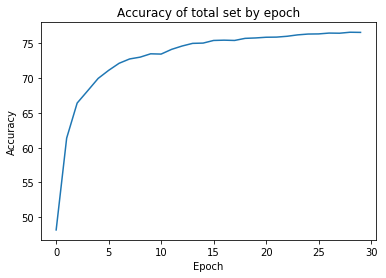

In [17]:
#Plot the accuracy gain
plt.plot(AccuracyCount)
plt.title('Accuracy of total set by epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

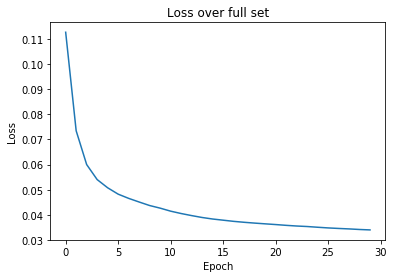

In [18]:
#Plot the loss rate
#Plot the accuracy gain
plt.plot(LossCount)
plt.title('Loss over full set')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [11]:
#Update the weights.

### Accuracy of loaded weights

In [15]:
#Load some weights
weights = loadData("ex3weights.mat")
classifier.loadWeight(weights)

torch.Size([25, 400])
tensor([-0.0226, -0.0984,  0.1162, -0.2397, -0.7316, -0.5979,  0.1546, -0.0337,
        -0.4107,  0.0235,  0.2477,  0.2653,  0.0943,  0.2022, -0.2030,  0.1046,
         0.1489, -0.0379, -0.3320, -0.2977, -0.4842, -0.3898, -0.1832, -0.7021,
        -0.3509])
tensor([-0.7610, -0.6179, -0.6893, -0.6783, -0.5966, -0.8779, -0.5275, -0.7490,
        -0.6665, -0.4609])
